# 🌿 Train NDVI-Weighted Models

**Objective:** Train improved CNN models that emphasize NDVI change

**Key Improvements:**
1. **Channel Attention** - Model learns importance of each channel (NDVI gets higher weight)
2. **NDVI Difference Branch** - Explicit NDVI change modeling
3. **Feature Fusion** - Combine spatial features with NDVI change

**Hypothesis:** By emphasizing NDVI change, models should better align with ground truth

**Expected time:** 20-30 minutes per model

## 1. Setup

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
src_path = project_root / 'src'

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"Source dir: {src_path}")

Project root: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH
Source dir: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\src


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import from src
from src.dataset import DeforestationDataset
from src.models_ndvi_weighted import get_ndvi_weighted_model, count_parameters

print("✅ Libraries imported successfully!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch: 1.13.1+cu117
CUDA available: True
GPU: NVIDIA RTX A4000


## 2. Configuration

In [3]:
# Paths
PATCHES_DIR = Path('../data/patches')
CHECKPOINTS_DIR = Path('../checkpoints')
LOGS_DIR = Path('../logs')
FIGURES_DIR = Path('../figures')

CHECKPOINTS_DIR.mkdir(exist_ok=True)
LOGS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

# Training config
CONFIG = {
    'batch_size': 64,
    'num_workers': 8,
    'prefetch_factor': 3,
    'persistent_workers': True,
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'use_amp': True,
    'patience': 10,
    'reduce_lr_patience': 5,
    'min_lr': 1e-6,
    'random_seed': 42
}

torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

print("✅ Configuration set")

✅ Configuration set


## 3. Load Datasets

In [4]:
print("Loading datasets...\n")

train_dataset = DeforestationDataset(str(PATCHES_DIR / 'train'), augment=True)
val_dataset = DeforestationDataset(str(PATCHES_DIR / 'val'), augment=False)
test_dataset = DeforestationDataset(str(PATCHES_DIR / 'test'), augment=False)

train_loader = DataLoader(
    train_dataset, batch_size=CONFIG['batch_size'], shuffle=True,
    num_workers=CONFIG['num_workers'], pin_memory=True,
    prefetch_factor=CONFIG['prefetch_factor'],
    persistent_workers=CONFIG['persistent_workers']
)

val_loader = DataLoader(
    val_dataset, batch_size=CONFIG['batch_size'], shuffle=False,
    num_workers=CONFIG['num_workers'], pin_memory=True,
    prefetch_factor=CONFIG['prefetch_factor'],
    persistent_workers=CONFIG['persistent_workers']
)

print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Val: {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"Test: {len(test_dataset)} samples")

Loading datasets...

✅ Dataset loaded: 899 patches
   Class 0 (No deforestation): 454
   Class 1 (Deforestation): 445
✅ Dataset loaded: 193 patches
   Class 0 (No deforestation): 98
   Class 1 (Deforestation): 95
✅ Dataset loaded: 193 patches
   Class 0 (No deforestation): 98
   Class 1 (Deforestation): 95
Train: 899 samples, 15 batches
Val: 193 samples, 4 batches
Test: 193 samples


## 4. Test NDVI-Weighted Models

In [5]:
print("Testing NDVI-Weighted Models\n")
print("="*80)

# Test different configurations
test_configs = [
    {
        'name': 'Full (Attention + NDVI Branch)',
        'use_channel_attention': True,
        'use_ndvi_branch': True
    },
    {
        'name': 'Attention Only',
        'use_channel_attention': True,
        'use_ndvi_branch': False
    },
    {
        'name': 'NDVI Branch Only',
        'use_channel_attention': False,
        'use_ndvi_branch': True
    }
]

x_test = torch.randn(2, 14, 128, 128)

for config in test_configs:
    model = get_ndvi_weighted_model(
        'multiscale_cnn',
        in_channels=14,
        use_channel_attention=config['use_channel_attention'],
        use_ndvi_branch=config['use_ndvi_branch']
    )
    
    with torch.no_grad():
        y = model(x_test)
    
    params = count_parameters(model)
    
    print(f"\n{config['name']}:")
    print(f"  Parameters: {params:,}")
    print(f"  Output shape: {y.shape}")
    print(f"  Channel Attention: {'✓' if config['use_channel_attention'] else '✗'}")
    print(f"  NDVI Branch: {'✓' if config['use_ndvi_branch'] else '✗'}")

print("\n" + "="*80)

Testing NDVI-Weighted Models


Full (Attention + NDVI Branch):
  Parameters: 259,397
  Output shape: torch.Size([2, 1, 128, 128])
  Channel Attention: ✓
  NDVI Branch: ✓

Attention Only:
  Parameters: 247,637
  Output shape: torch.Size([2, 1, 128, 128])
  Channel Attention: ✓
  NDVI Branch: ✗

NDVI Branch Only:
  Parameters: 259,313
  Output shape: torch.Size([2, 1, 128, 128])
  Channel Attention: ✗
  NDVI Branch: ✓



## 5. Visualize NDVI Change on Sample

Before training, let's verify NDVI change is meaningful

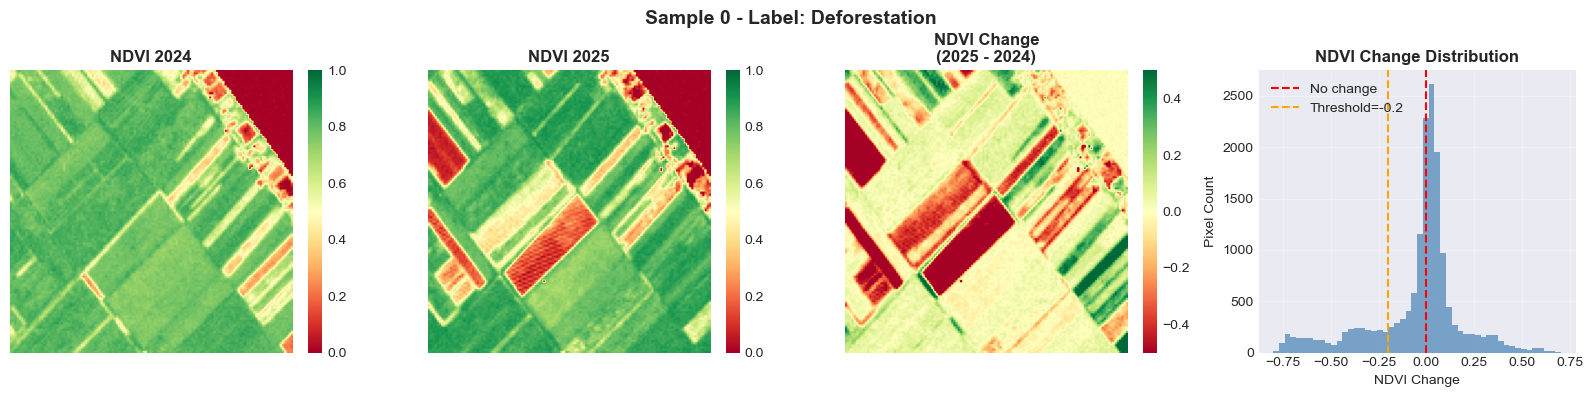

NDVI Change Statistics:
  Mean: -0.0463
  Std: 0.2412
  Min: -0.8020
  Max: 0.7063
  Pixels < -0.2: 3137 (19.1%)


In [6]:
# Get a sample
sample_idx = 0
patch, label = train_dataset[sample_idx]

# Extract NDVI
ndvi_2024 = patch[4].numpy()  # NDVI 2024
ndvi_2025 = patch[11].numpy()  # NDVI 2025
ndvi_change = ndvi_2025 - ndvi_2024

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# NDVI 2024
im1 = axes[0].imshow(ndvi_2024, cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title('NDVI 2024', fontweight='bold')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# NDVI 2025
im2 = axes[1].imshow(ndvi_2025, cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title('NDVI 2025', fontweight='bold')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# NDVI Change
im3 = axes[2].imshow(ndvi_change, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
axes[2].set_title('NDVI Change\n(2025 - 2024)', fontweight='bold')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046)

# Histogram
axes[3].hist(ndvi_change.flatten(), bins=50, color='steelblue', alpha=0.7)
axes[3].axvline(0, color='red', linestyle='--', label='No change')
axes[3].axvline(-0.2, color='orange', linestyle='--', label='Threshold=-0.2')
axes[3].set_xlabel('NDVI Change')
axes[3].set_ylabel('Pixel Count')
axes[3].set_title('NDVI Change Distribution', fontweight='bold')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.suptitle(f'Sample {sample_idx} - Label: {"Deforestation" if label==1 else "No Deforestation"}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"NDVI Change Statistics:")
print(f"  Mean: {ndvi_change.mean():.4f}")
print(f"  Std: {ndvi_change.std():.4f}")
print(f"  Min: {ndvi_change.min():.4f}")
print(f"  Max: {ndvi_change.max():.4f}")
print(f"  Pixels < -0.2: {(ndvi_change < -0.2).sum()} ({(ndvi_change < -0.2).mean()*100:.1f}%)")

## 6. Training Function (Same as before)

In [7]:
# Copy training function from notebook 03
# (Same implementation, works with new models)

def train_model(model, model_name, train_loader, val_loader, config):
    device = config['device']
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scaler = GradScaler() if config['use_amp'] else None
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                       patience=config['reduce_lr_patience'], min_lr=config['min_lr'])
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'learning_rate': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")
    print(f"Parameters: {count_parameters(model):,}")
    print(f"{'='*80}\n")
    
    start_time = time.time()
    
    for epoch in range(config['num_epochs']):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for patches, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False):
            patches = patches.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(1).float()
            
            optimizer.zero_grad(set_to_none=True)
            
            if config['use_amp']:
                with autocast():
                    outputs = model(patches)
                    outputs_pooled = outputs.mean(dim=[2, 3])
                    loss = criterion(outputs_pooled, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(patches)
                outputs_pooled = outputs.mean(dim=[2, 3])
                loss = criterion(outputs_pooled, labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item() * patches.size(0)
            predictions = (torch.sigmoid(outputs_pooled) > 0.5).float()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for patches, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]  ", leave=False):
                patches = patches.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True).unsqueeze(1).float()
                
                if config['use_amp']:
                    with autocast():
                        outputs = model(patches)
                        outputs_pooled = outputs.mean(dim=[2, 3])
                        loss = criterion(outputs_pooled, labels)
                else:
                    outputs = model(patches)
                    outputs_pooled = outputs.mean(dim=[2, 3])
                    loss = criterion(outputs_pooled, labels)
                
                val_loss += loss.item() * patches.size(0)
                predictions = (torch.sigmoid(outputs_pooled) > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)
        
        print(f"Epoch {epoch+1:3d}/{config['num_epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {100*train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {100*val_acc:.2f}% | "
              f"LR: {current_lr:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            checkpoint_path = CHECKPOINTS_DIR / f"{model_name}_best.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
                'history': history
            }, checkpoint_path)
            print(f"  💾 Saved best model (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
        
        if patience_counter >= config['patience']:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break
    
    elapsed = time.time() - start_time
    print(f"\n⏱️ Training completed in {elapsed/60:.1f} minutes")
    print(f"✅ Best val loss: {best_val_loss:.4f}")
    
    return history

## 7. Train NDVI-Weighted MultiScale CNN

Train with FULL configuration (Channel Attention + NDVI Branch)

In [8]:
# Create model with both improvements
model_ndvi = get_ndvi_weighted_model(
    'multiscale_cnn',
    in_channels=14,
    use_channel_attention=True,
    use_ndvi_branch=True
)

# Train
history_ndvi = train_model(
    model=model_ndvi,
    model_name='multiscale_cnn_ndvi_weighted',
    train_loader=train_loader,
    val_loader=val_loader,
    config=CONFIG
)


Training multiscale_cnn_ndvi_weighted
Parameters: 259,397



Epoch 1/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   1/100 | Train Loss: 0.5444 Acc: 76.08% | Val Loss: 0.7049 Acc: 50.78% | LR: 0.001000
  💾 Saved best model (val_loss: 0.7049)


Epoch 2/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   2/100 | Train Loss: 0.4763 Acc: 81.20% | Val Loss: 0.7163 Acc: 51.30% | LR: 0.001000


Epoch 3/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   3/100 | Train Loss: 0.4602 Acc: 81.87% | Val Loss: 0.6135 Acc: 58.03% | LR: 0.001000
  💾 Saved best model (val_loss: 0.6135)


Epoch 4/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   4/100 | Train Loss: 0.4391 Acc: 82.31% | Val Loss: 0.4800 Acc: 80.31% | LR: 0.001000
  💾 Saved best model (val_loss: 0.4800)


Epoch 5/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   5/100 | Train Loss: 0.4208 Acc: 84.20% | Val Loss: 0.4203 Acc: 82.90% | LR: 0.001000
  💾 Saved best model (val_loss: 0.4203)


Epoch 6/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   6/100 | Train Loss: 0.4076 Acc: 84.43% | Val Loss: 0.3736 Acc: 84.97% | LR: 0.001000
  💾 Saved best model (val_loss: 0.3736)


Epoch 7/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   7/100 | Train Loss: 0.3867 Acc: 84.65% | Val Loss: 0.4102 Acc: 84.46% | LR: 0.001000


Epoch 8/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   8/100 | Train Loss: 0.3653 Acc: 85.65% | Val Loss: 0.4102 Acc: 86.01% | LR: 0.001000


Epoch 9/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   9/100 | Train Loss: 0.3565 Acc: 85.98% | Val Loss: 0.5068 Acc: 71.50% | LR: 0.001000


Epoch 10/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  10/100 | Train Loss: 0.3763 Acc: 84.43% | Val Loss: 1.2367 Acc: 55.96% | LR: 0.001000


Epoch 11/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  11/100 | Train Loss: 0.3684 Acc: 84.87% | Val Loss: 0.4274 Acc: 82.90% | LR: 0.001000


Epoch 12/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  12/100 | Train Loss: 0.3489 Acc: 85.54% | Val Loss: 0.4754 Acc: 80.83% | LR: 0.000500


Epoch 13/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  13/100 | Train Loss: 0.3494 Acc: 85.98% | Val Loss: 0.3329 Acc: 84.97% | LR: 0.000500
  💾 Saved best model (val_loss: 0.3329)


Epoch 14/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  14/100 | Train Loss: 0.3227 Acc: 88.21% | Val Loss: 0.3328 Acc: 89.64% | LR: 0.000500
  💾 Saved best model (val_loss: 0.3328)


Epoch 15/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  15/100 | Train Loss: 0.3235 Acc: 87.99% | Val Loss: 0.3281 Acc: 88.60% | LR: 0.000500
  💾 Saved best model (val_loss: 0.3281)


Epoch 16/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  16/100 | Train Loss: 0.3198 Acc: 88.32% | Val Loss: 0.4900 Acc: 78.24% | LR: 0.000500


Epoch 17/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  17/100 | Train Loss: 0.3241 Acc: 87.32% | Val Loss: 0.3600 Acc: 82.90% | LR: 0.000500


Epoch 18/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  18/100 | Train Loss: 0.3089 Acc: 89.32% | Val Loss: 0.3080 Acc: 89.12% | LR: 0.000500
  💾 Saved best model (val_loss: 0.3080)


Epoch 19/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  19/100 | Train Loss: 0.3062 Acc: 88.43% | Val Loss: 0.4079 Acc: 79.79% | LR: 0.000500


Epoch 20/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  20/100 | Train Loss: 0.3113 Acc: 88.65% | Val Loss: 0.3330 Acc: 87.05% | LR: 0.000500


Epoch 21/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  21/100 | Train Loss: 0.3013 Acc: 88.65% | Val Loss: 0.3725 Acc: 83.42% | LR: 0.000500


Epoch 22/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  22/100 | Train Loss: 0.3063 Acc: 89.10% | Val Loss: 0.3148 Acc: 86.53% | LR: 0.000500


Epoch 23/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  23/100 | Train Loss: 0.2853 Acc: 89.99% | Val Loss: 0.3096 Acc: 88.08% | LR: 0.000500


Epoch 24/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  24/100 | Train Loss: 0.2985 Acc: 88.77% | Val Loss: 0.7802 Acc: 69.43% | LR: 0.000250


Epoch 25/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  25/100 | Train Loss: 0.2891 Acc: 88.99% | Val Loss: 0.2972 Acc: 89.12% | LR: 0.000250
  💾 Saved best model (val_loss: 0.2972)


Epoch 26/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  26/100 | Train Loss: 0.2841 Acc: 89.21% | Val Loss: 0.2838 Acc: 88.08% | LR: 0.000250
  💾 Saved best model (val_loss: 0.2838)


Epoch 27/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  27/100 | Train Loss: 0.2789 Acc: 88.54% | Val Loss: 0.2900 Acc: 89.64% | LR: 0.000250


Epoch 28/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  28/100 | Train Loss: 0.2783 Acc: 89.88% | Val Loss: 0.2836 Acc: 90.16% | LR: 0.000250
  💾 Saved best model (val_loss: 0.2836)


Epoch 29/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  29/100 | Train Loss: 0.2796 Acc: 89.88% | Val Loss: 0.2681 Acc: 89.64% | LR: 0.000250
  💾 Saved best model (val_loss: 0.2681)


Epoch 30/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  30/100 | Train Loss: 0.2707 Acc: 89.10% | Val Loss: 0.2981 Acc: 88.60% | LR: 0.000250


Epoch 31/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  31/100 | Train Loss: 0.2665 Acc: 90.10% | Val Loss: 0.2834 Acc: 90.16% | LR: 0.000250


Epoch 32/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  32/100 | Train Loss: 0.2685 Acc: 90.32% | Val Loss: 0.2818 Acc: 90.16% | LR: 0.000250


Epoch 33/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  33/100 | Train Loss: 0.2645 Acc: 90.21% | Val Loss: 0.2764 Acc: 89.12% | LR: 0.000250


Epoch 34/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  34/100 | Train Loss: 0.2643 Acc: 90.32% | Val Loss: 0.2691 Acc: 90.16% | LR: 0.000250


Epoch 35/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  35/100 | Train Loss: 0.2733 Acc: 90.10% | Val Loss: 0.4722 Acc: 79.79% | LR: 0.000125


Epoch 36/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  36/100 | Train Loss: 0.2701 Acc: 89.77% | Val Loss: 0.2674 Acc: 90.16% | LR: 0.000125
  💾 Saved best model (val_loss: 0.2674)


Epoch 37/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  37/100 | Train Loss: 0.2707 Acc: 90.32% | Val Loss: 0.2642 Acc: 90.67% | LR: 0.000125
  💾 Saved best model (val_loss: 0.2642)


Epoch 38/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  38/100 | Train Loss: 0.2612 Acc: 90.32% | Val Loss: 0.2809 Acc: 89.64% | LR: 0.000125


Epoch 39/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  39/100 | Train Loss: 0.2626 Acc: 91.10% | Val Loss: 0.2694 Acc: 90.16% | LR: 0.000125


Epoch 40/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  40/100 | Train Loss: 0.2623 Acc: 89.32% | Val Loss: 0.2807 Acc: 88.60% | LR: 0.000125


Epoch 41/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  41/100 | Train Loss: 0.2636 Acc: 89.99% | Val Loss: 0.2614 Acc: 91.19% | LR: 0.000125
  💾 Saved best model (val_loss: 0.2614)


Epoch 42/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  42/100 | Train Loss: 0.2551 Acc: 90.21% | Val Loss: 0.2637 Acc: 90.67% | LR: 0.000125


Epoch 43/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  43/100 | Train Loss: 0.2554 Acc: 91.32% | Val Loss: 0.2557 Acc: 91.71% | LR: 0.000125
  💾 Saved best model (val_loss: 0.2557)


Epoch 44/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  44/100 | Train Loss: 0.2543 Acc: 91.55% | Val Loss: 0.2720 Acc: 88.60% | LR: 0.000125


Epoch 45/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  45/100 | Train Loss: 0.2505 Acc: 91.21% | Val Loss: 0.2845 Acc: 88.08% | LR: 0.000125


Epoch 46/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  46/100 | Train Loss: 0.2581 Acc: 90.77% | Val Loss: 0.2618 Acc: 89.12% | LR: 0.000125


Epoch 47/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  47/100 | Train Loss: 0.2688 Acc: 90.32% | Val Loss: 0.2580 Acc: 91.19% | LR: 0.000125


Epoch 48/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  48/100 | Train Loss: 0.2644 Acc: 90.10% | Val Loss: 0.2916 Acc: 88.60% | LR: 0.000125


Epoch 49/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  49/100 | Train Loss: 0.2579 Acc: 89.99% | Val Loss: 0.2591 Acc: 90.67% | LR: 0.000063


Epoch 50/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  50/100 | Train Loss: 0.2528 Acc: 90.21% | Val Loss: 0.2610 Acc: 90.16% | LR: 0.000063


Epoch 51/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 51/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  51/100 | Train Loss: 0.2484 Acc: 90.77% | Val Loss: 0.2605 Acc: 91.19% | LR: 0.000063


Epoch 52/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 52/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  52/100 | Train Loss: 0.2502 Acc: 90.77% | Val Loss: 0.2748 Acc: 90.16% | LR: 0.000063


Epoch 53/100 [Train]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 53/100 [Val]  :   0%|          | 0/4 [00:00<?, ?it/s]

Epoch  53/100 | Train Loss: 0.2515 Acc: 90.32% | Val Loss: 0.2747 Acc: 91.19% | LR: 0.000063

⚠️ Early stopping at epoch 53

⏱️ Training completed in 3.9 minutes
✅ Best val loss: 0.2557


## 8. Compare with Original Model

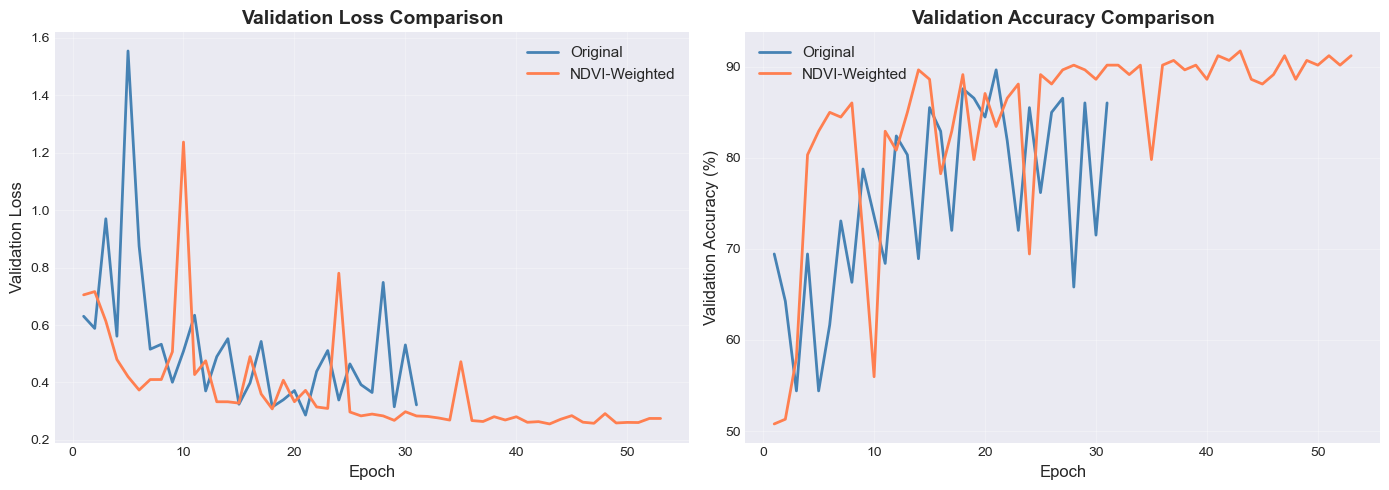


BEST RESULTS COMPARISON

Original MultiScale CNN:
  Best Epoch: 21
  Val Loss: 0.2866
  Val Acc: 89.64%

NDVI-Weighted MultiScale CNN:
  Best Epoch: 43
  Val Loss: 0.2557
  Val Acc: 91.71%

📊 Improvement: +10.77% in validation loss


In [9]:
# Load original model history for comparison
original_history_path = LOGS_DIR / 'multiscale_cnn_history.csv'

if original_history_path.exists():
    df_original = pd.read_csv(original_history_path)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Validation loss
    axes[0].plot(df_original['epoch'], df_original['val_loss'], 
                label='Original', linewidth=2, color='steelblue')
    axes[0].plot(range(1, len(history_ndvi['val_loss'])+1), history_ndvi['val_loss'],
                label='NDVI-Weighted', linewidth=2, color='coral')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Loss', fontsize=12)
    axes[0].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # Validation accuracy
    axes[1].plot(df_original['epoch'], df_original['val_acc']*100,
                label='Original', linewidth=2, color='steelblue')
    axes[1].plot(range(1, len(history_ndvi['val_acc'])+1), 
                [acc*100 for acc in history_ndvi['val_acc']],
                label='NDVI-Weighted', linewidth=2, color='coral')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'ndvi_weighted_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print best results
    print("\n" + "="*80)
    print("BEST RESULTS COMPARISON")
    print("="*80)
    
    orig_best_val_loss = df_original['val_loss'].min()
    orig_best_epoch = df_original['val_loss'].idxmin() + 1
    orig_best_val_acc = df_original.iloc[orig_best_epoch-1]['val_acc'] * 100
    
    ndvi_best_val_loss = min(history_ndvi['val_loss'])
    ndvi_best_epoch = history_ndvi['val_loss'].index(ndvi_best_val_loss) + 1
    ndvi_best_val_acc = history_ndvi['val_acc'][ndvi_best_epoch-1] * 100
    
    print(f"\nOriginal MultiScale CNN:")
    print(f"  Best Epoch: {orig_best_epoch}")
    print(f"  Val Loss: {orig_best_val_loss:.4f}")
    print(f"  Val Acc: {orig_best_val_acc:.2f}%")
    
    print(f"\nNDVI-Weighted MultiScale CNN:")
    print(f"  Best Epoch: {ndvi_best_epoch}")
    print(f"  Val Loss: {ndvi_best_val_loss:.4f}")
    print(f"  Val Acc: {ndvi_best_val_acc:.2f}%")
    
    improvement = ((orig_best_val_loss - ndvi_best_val_loss) / orig_best_val_loss) * 100
    print(f"\n📊 Improvement: {improvement:+.2f}% in validation loss")
    
else:
    print("⚠️ Original model history not found. Run notebook 03 first.")

## 9. Summary

In [10]:
print("\n" + "="*80)
print("NDVI-WEIGHTED MODEL TRAINING COMPLETE")
print("="*80)

print("\n✅ Key Features:")
print("  1. Channel Attention - Model learns to weight NDVI higher")
print("  2. NDVI Difference Branch - Explicit NDVI change modeling")
print("  3. Feature Fusion - Combines spatial + temporal information")

print("\n📁 Output:")
print(f"  Checkpoint: {CHECKPOINTS_DIR / 'multiscale_cnn_ndvi_weighted_best.pth'}")
print(f"  Figures: {FIGURES_DIR / 'ndvi_weighted_comparison.png'}")

print("\n🚀 Next Steps:")
print("  1. Evaluate on test set")
print("  2. Compare predictions with original model")
print("  3. Check if predictions align better with NDVI change")

print("\n" + "="*80)


NDVI-WEIGHTED MODEL TRAINING COMPLETE

✅ Key Features:
  1. Channel Attention - Model learns to weight NDVI higher
  2. NDVI Difference Branch - Explicit NDVI change modeling
  3. Feature Fusion - Combines spatial + temporal information

📁 Output:
  Checkpoint: ..\checkpoints\multiscale_cnn_ndvi_weighted_best.pth
  Figures: ..\figures\ndvi_weighted_comparison.png

🚀 Next Steps:
  1. Evaluate on test set
  2. Compare predictions with original model
  3. Check if predictions align better with NDVI change

